In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import sys, os
import sklearn
import datetime

import importlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
import st_toolkit as geohl
importlib.reload(geohl)

import cri_calc as cri
importlib.reload(cri)

import cri_helper as helper
importlib.reload(helper)

import nn_evaluation as nne
importlib.reload(nne)

<module 'nn_evaluation' from '/Users/andrewt/Documents/Univ. Piraeus Research Center/VCRA/nn_evaluation.py'>

In [3]:
def calculate_cri(rec_own, rec_target):
    own = rec_own._asdict()
    target = rec_target._asdict()
    
    ves_dcpa, ves_tcpa, hr, rel_movement_angle, dist_euclid, speed_r = cri.colregs_alarms(own=own, target=target)
    ves_cri = cri.calculate_cri(own, target, ves_dcpa, ves_tcpa, hr, rel_movement_angle, dist_euclid, speed_r)
    
    return ves_dcpa, ves_tcpa, hr, rel_movement_angle, dist_euclid, speed_r, ves_cri

In [4]:
def calculate_cri_timeslice(df):
    timeslice_result = []
    
    for row_i in df.itertuples():
        for row_j in df.itertuples():
            if row_i.Index == row_j.Index:
                continue
                
            timeslice_result.append([row_i.Index, row_i.mmsi, row_i.geom, row_i.speed, row_i.course, 
                                     row_j.Index, row_j.mmsi, row_j.geom, row_j.speed, row_j.course, *calculate_cri(row_i, row_j)])
            
    return pd.DataFrame(timeslice_result, columns=['own_Index', 'own_mmsi', 'own_geom', 'own_speed', 'own_course',
                                                   'target_Index', 'target_mmsi', 'target_geom', 'target_speed', 'target_course', 
                                                   'dcpa', 'tcpa', 'hr', 'rel_movement_angle', 'dist_euclid', 'speed_r', 'cri'])

# Load Data

In [5]:
df = pd.read_csv('./data/unipi_ais_dynamic_jul2018_1w_algn_linear_v2_w_lens.csv', parse_dates=['datetime'])
gdf = geohl.getGeoDataFrame_v2(df, crs='epsg:4326')

/Users/andrewt/miniforge3/envs/vesai/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [6]:
gdf2 = gdf.loc[gdf.datetime.dt.date.between(datetime.date(2018, 7, 3), datetime.date(2018, 7, 3), inclusive='both')].copy()

In [7]:
gdf_sub_moving = gdf2.loc[gdf2.speed.between(1, 50, inclusive='neither')].copy()

# Creating Training Dataset

In [ ]:
# tqdm.pandas()
# gdf_vcra = gdf_sub_moving.groupby(['datetime']).progress_apply(lambda l: calculate_cri_timeslice(l.copy()))

In [ ]:
from joblib import Parallel, delayed
import multiprocessing


def applyParallel(dfGrouped, func, n_jobs=-1):
    '''
    Forked from: https://stackoverflow.com/a/27027632
    '''
    n_jobs = multiprocessing.cpu_count() if n_jobs == -1 else n_jobs
    print(f'Scaling {func} to {n_jobs} CPUs')
    
    retLst = Parallel(n_jobs=n_jobs)(delayed(func)(group) for name, group in tqdm(dfGrouped))
    return pd.concat(retLst)


gdf_vcra = applyParallel(gdf_sub_moving.groupby(['datetime']), lambda l: calculate_cri_timeslice(l.copy()), 7)

In [ ]:
gdf_vcra_mi = gdf_vcra.copy()
gdf_vcra_mi = pd.merge(gdf_vcra_mi, gdf_sub_moving.datetime, left_on='own_Index', right_index=True)
gdf_vcra_mi.set_index(['datetime'], inplace=True)

In [ ]:
gdf_vcra_mi.to_pickle('./data/unipi_ais_dynamic_jul2018_1w_vcra_dataset_v3.pickle')

# Loading and Preparing CRI Dataset

In [8]:
gdf_vcra = pd.read_pickle('./data/unipi_ais_dynamic_jul2018_1w_vcra_dataset_v3.pickle')

In [9]:
tqdm.pandas(desc='Adding Vessels\' Length...')

mlp_input = gdf_vcra.loc[gdf_vcra.own_Index.isin(gdf_sub_moving.index.values)].copy()
mlp_input.loc[:, 'own_length'] = mlp_input.own_Index.progress_apply(lambda l: gdf_sub_moving.loc[l].length)
mlp_input.loc[:, 'cri_bin'] = pd.cut(mlp_input.cri, bins=np.arange(0, 1.1, .1), right=False,)

Adding Vessels' Length...: 100%|█████| 960268/960268 [00:35<00:00, 27071.05it/s]


In [10]:
X = mlp_input[['dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course', 'own_length']].values
y = mlp_input[['cri']].values.ravel()

# Training an MLP (via sklearn)

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=mlp_input['cri_bin'])

scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)

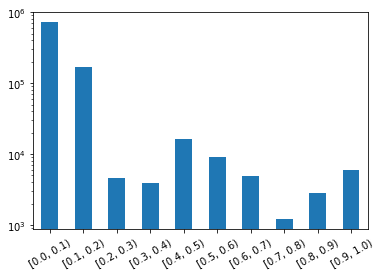

In [32]:
fig, ax = plt.subplots(1,1)
mlp_input.cri_bin.value_counts(sort=False).plot.bar(ax=ax, rot=30)
ax.set_yscale('log')

In [33]:
regr = MLPRegressor(random_state=10, max_iter=30, hidden_layer_sizes=(256, 32), 
                    verbose=True, early_stopping=True, n_iter_no_change=10).fit(X_train_norm, y_train)

regr.score(scaler.transform(X_test), y_test)

Iteration 1, loss = 0.00379227
Validation score: 0.697275
Iteration 2, loss = 0.00252789
Validation score: 0.735621
Iteration 3, loss = 0.00225819
Validation score: 0.749329
Iteration 4, loss = 0.00208126
Validation score: 0.777629
Iteration 5, loss = 0.00198242
Validation score: 0.783244
Iteration 6, loss = 0.00189374
Validation score: 0.813177
Iteration 7, loss = 0.00184354
Validation score: 0.802359
Iteration 8, loss = 0.00177591
Validation score: 0.817835
Iteration 9, loss = 0.00173640
Validation score: 0.816365
Iteration 10, loss = 0.00169408
Validation score: 0.826940
Iteration 11, loss = 0.00165977
Validation score: 0.838854
Iteration 12, loss = 0.00163004
Validation score: 0.837390
Iteration 13, loss = 0.00161024
Validation score: 0.830170
Iteration 14, loss = 0.00157001
Validation score: 0.821505
Iteration 15, loss = 0.00154639
Validation score: 0.844907
Iteration 16, loss = 0.00152386
Validation score: 0.831207
Iteration 17, loss = 0.00150701
Validation score: 0.850490
Iterat

/Users/andrewt/miniforge3/envs/vesai/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(


0.858409721161965

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

cri_pred = pd.Series(regr.predict(scaler.transform(X_test))).clip(0,1).values
print(f'MAE: {mean_absolute_error(y_test, cri_pred)}')
print(f'RMSE: {mean_squared_error(y_test, cri_pred, squared=False)}')

MAE: 0.01958298955941779
RMSE: 0.05023021059397274


In [35]:
from joblib import dump, load
dump(regr, './data/vcra-1w-mlp-hidden_256_32-ours.model.joblib') 
dump(scaler, './data/vcra-1w-mlp-hidden_256_32-ours.scaler.joblib') 

['./data/vcra-1w-mlp-hidden_256_32-ours.scaler.joblib']

# Evaluating ML model timeliness

In [36]:
from joblib import dump, load
regr_ours = load('./data/vcra-1w-mlp-hidden_256_32-ours.model.joblib') 

In [37]:
grouped = gdf_sub_moving.groupby(['datetime'])
l = grouped.get_group((list(grouped.groups)[0]))

In [39]:
%%timeit 
nne.calc_cri_timeslice(l.copy(), model=regr_ours, model_fun=nne.calc_cri_ours_with_own_length, model_norm=scaler);

167 ms ± 335 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
